In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''        
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import torch.nn as nn
import torch
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import sys
from timm.models.vision_transformer import Block
import torch.nn.functional as F
import math
# from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
import time
import timm.optim.optim_factory as optim_factory
import datetime
import copy
from scipy.interpolate import interp1d
from torch.utils.data import Dataset
from torch import inf
import mne
from scipy.signal import spectrogram, istft
import numpy as np
from scipy.signal import butter, filtfilt
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
#pip install torch

/usr/local/lib/python3.10/dist-packages/timm/optim/optim_factory.py:7: FutureWarning: Importing from timm.optim.optim_factory is deprecated, please import via timm.optim
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.optim", FutureWarning)


In [3]:
pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch_geometric.loader import DataLoader

In [5]:
process_file_pth = "/kaggle/input/main-dla-mae-saliency/eeg_5_95_std.pth"
split_path = "/kaggle/input/main-dla-mae-saliency/block_splits_by_image_single.pth"
imgNet_path = "/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images"

In [6]:
try:
    loaded_data_new = torch.load(process_file_pth)
except FileNotFoundError:
    print(f"The file {split_path} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

splits = loaded_data_new.keys()
print(splits)

<ipython-input-6-9547b123b1a2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data_new = torch.load(process_file_pth)


dict_keys(['dataset', 'labels', 'images'])


In [7]:
dataset_new = loaded_data_new["dataset"]
labels_new = loaded_data_new["labels"]
images_new = loaded_data_new["images"]

dataset_new = np.array(dataset_new)
labels_new = np.array(labels_new)
images_new = np.array(images_new)

dataset_image = [dataset_new[i]["image"] for i in range(len(dataset_new))]
dataset_label = [dataset_new[i]["label"] for i in range(len(dataset_new))]
dataset_eeg = [dataset_new[i]["eeg"] for i in range(len(dataset_new))]
eeg_data = np.array([i[:,20:470].float() for i in dataset_eeg])
dataset_subject = [dataset_new[i]["subject"] for i in range(len(dataset_new))]

In [8]:
import gc
gc.collect()

8

In [9]:
dataset_corresponding_image = []
for index, value in enumerate(dataset_image):
    dataset_corresponding_image.append(images_new[value])
dataset_corresponding_image = np.array(dataset_corresponding_image)

In [10]:
image_paths = [
    imgNet_path +"/"+ img.split("_")[0] + "/" + str(img) + ".JPEG" for img in dataset_corresponding_image]

In [11]:
eeg_list = [eeg[:,20:470] for eeg in dataset_eeg]
print(dataset_eeg[0].shape)

torch.Size([128, 500])


Failed to process image n03452741_17620.JPEG
THis was saved instead


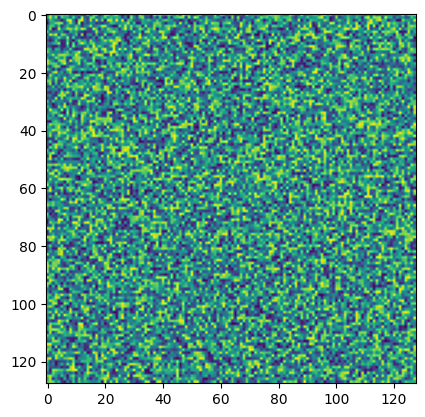

In [12]:
output_file = "/kaggle/working/all_images"
if not os.path.exists(output_file):   
    os.makedirs(output_file)

count = 0
for subdir, _, files in os.walk(imgNet_path):
    for item in files:
        count+=1
        if item.endswith(".JPEG"):
            try:
                image_path = os.path.join(subdir, item)
                #print(image_path)
                img = cv2.imread(image_path)
                #img = generate_depth_map(image_path)
                if img is not None:
                    #plt.imshow(img)
                    #plt.show()
                    save_subdir = os.path.join(output_file, os.path.basename(subdir))
                    if not os.path.exists(save_subdir):
                        os.makedirs(save_subdir)
                    save_file = os.path.join(save_subdir, item)
                    cv2.imwrite(save_file, img*255)  # Multiply by 255 to scale to image pixel range
                    #print(save_file)                      
                else:
                    print(f"Failed to process image {item}")
                    save_subdir = os.path.join(output_file, os.path.basename(subdir))
                    if not os.path.exists(save_subdir):
                        os.makedirs(save_subdir)
                    save_file = os.path.join(save_subdir, item)
                    random_image = np.random.rand(128, 128)  # Generate random 128x128 image
                    cv2.imwrite(save_file, random_image*255)  # Multiply by 255 to scale to image pixel range
                    print("THis was saved instead")
                    plt.imshow(random_image)
                    plt.show()
            except Exception as e:
                print(f"Error with image {item}: {e}")
                continue

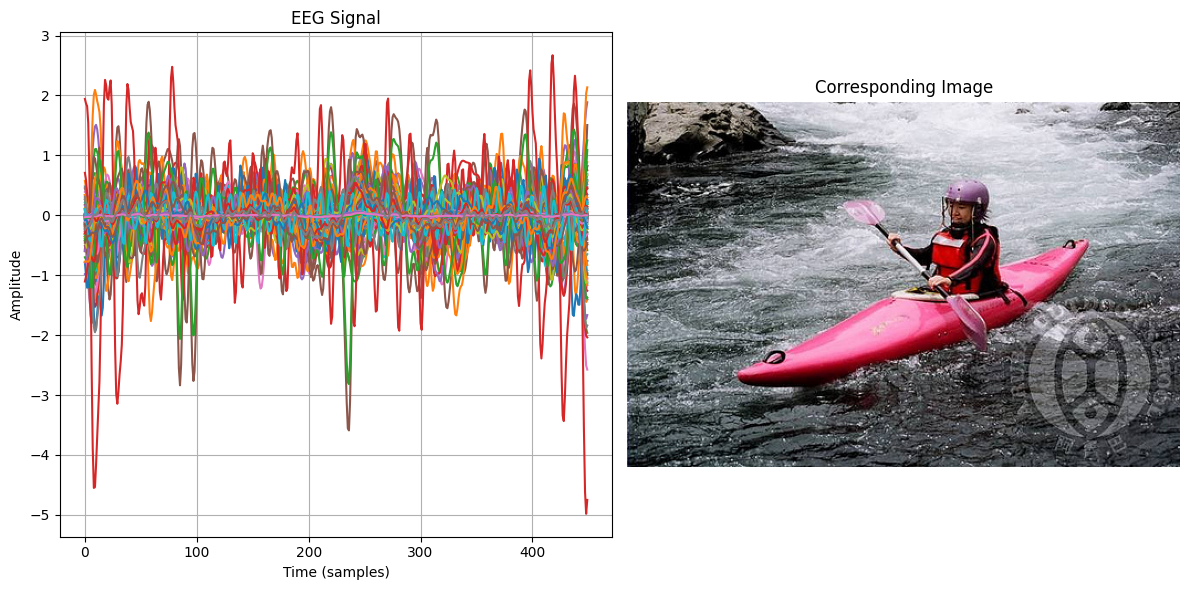

In [13]:
import matplotlib.pyplot as plt

# Function to plot EEG signal and corresponding image
def plot_eeg_with_image(eeg_signal, image_path):
    # Create a figure with two subplots: one for the EEG signal and one for the image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the EEG signal
    ax1.plot(eeg_signal.T)  # Transpose to get time series on x-axis
    ax1.set_title('EEG Signal')
    ax1.set_xlabel('Time (samples)')
    ax1.set_ylabel('Amplitude')
    ax1.grid()

    # Load and display the corresponding image
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
        ax2.imshow(img)
        ax2.axis('off')  # Hide axes for the image
        ax2.set_title('Corresponding Image')
    else:
        ax2.text(0.5, 0.5, 'Image not found', fontsize=12, ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Example usage of the function
# Assuming you want to plot the first EEG signal and its corresponding image
eeg_index = 0  # Change this index to plot different EEG signals and images
eeg_signal = eeg_data[eeg_index]
image_path = image_paths[eeg_index]

plot_eeg_with_image(eeg_signal, image_path)

In [14]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# BLIP-2 setup
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
model.to(device)

# Variables from notebook
imgNet_path = "/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images"
image_paths = [
    imgNet_path + "/" + img.split("_")[0] + "/" + str(img) + ".JPEG"
    for img in dataset_corresponding_image
]
eeg_list = [eeg[:, 20:470] for eeg in dataset_eeg]

# Save EEG directory (optional)
eeg_save_dir = "./eeg_signals"
os.makedirs(eeg_save_dir, exist_ok=True)

# Caption + Save
results = []

for idx, (img_path, eeg_signal) in tqdm(enumerate(zip(image_paths, eeg_list)), total=len(image_paths)):
    try:
        # Load and caption image
        image = Image.open(img_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device, torch.float16 if device == "cuda" else torch.float32)
        generated_ids = model.generate(**inputs, max_new_tokens=30)
        caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        # Save EEG signal as .npy
        eeg_filename = f"eeg_{idx}.npy"
        eeg_path = os.path.join(eeg_save_dir, eeg_filename)
        np.save(eeg_path, eeg_signal.cpu().numpy() if torch.is_tensor(eeg_signal) else eeg_signal)

        # Append to results
        results.append({
            "image_path": img_path,
            "caption": caption,
            "eeg_file": eeg_filename
        })
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        continue

# Export to CSV
df = pd.DataFrame(results)
df.to_csv("image_caption_eeg_mapping.csv", index=False)


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

  2%|▏         | 181/11965 [00:56<54:16,  3.62it/s]  

Error at index 180: cannot identify image file '/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG'


 18%|█▊        | 2176/11965 [11:37<55:25,  2.94it/s]  

Error at index 2176: cannot identify image file '/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG'


 35%|███▍      | 4161/11965 [22:11<43:43,  2.98it/s]  

Error at index 4161: cannot identify image file '/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG'


 51%|█████▏    | 6157/11965 [32:48<32:48,  2.95it/s]  

Error at index 6157: cannot identify image file '/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG'


 68%|██████▊   | 8153/11965 [43:23<21:24,  2.97it/s]

Error at index 8153: cannot identify image file '/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG'


 85%|████████▍ | 10149/11965 [53:59<10:13,  2.96it/s]

Error at index 10149: cannot identify image file '/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG'


100%|██████████| 11965/11965 [1:03:37<00:00,  3.13it/s]


In [13]:
import pandas as pd

data = pd.read_csv('/kaggle/input/eeg-caption-image-csv/image_caption_eeg_mapping.csv')
data

image_path  \
0      /kaggle/input/main-dla-mae-saliency/imageNet_i...   
1      /kaggle/input/main-dla-mae-saliency/imageNet_i...   
2      /kaggle/input/main-dla-mae-saliency/imageNet_i...   
3      /kaggle/input/main-dla-mae-saliency/imageNet_i...   
4      /kaggle/input/main-dla-mae-saliency/imageNet_i...   
...                                                  ...   
11954  /kaggle/input/main-dla-mae-saliency/imageNet_i...   
11955  /kaggle/input/main-dla-mae-saliency/imageNet_i...   
11956  /kaggle/input/main-dla-mae-saliency/imageNet_i...   
11957  /kaggle/input/main-dla-mae-saliency/imageNet_i...   
11958  /kaggle/input/main-dla-mae-saliency/imageNet_i...   

                                                 caption       eeg_file  
0      a young girl in a pink kayak paddling through ...      eeg_0.npy  
1                                a man playing a piano\n      eeg_1.npy  
2                    a canon camera with a strap on it\n      eeg_2.npy  
3            a man in a kayak paddling through a river\n      eeg_3.npy  
4                               a large christmas tree\n      eeg_4.npy  
...                                                  ...            ...  
11954   a white faced monkey walking through the grass\n  eeg_11960.npy  
11955                               a pizza on a table\n  eeg_11961.npy  
11956                    two clown fish in an anemonia\n  eeg_11962.npy  
11957             a black coffee machine with two cups\n  eeg_11963.npy  
11958               a pair of shoes with a tag on them\n  eeg_11964.npy  

[11959 rows x 3 columns]


Image


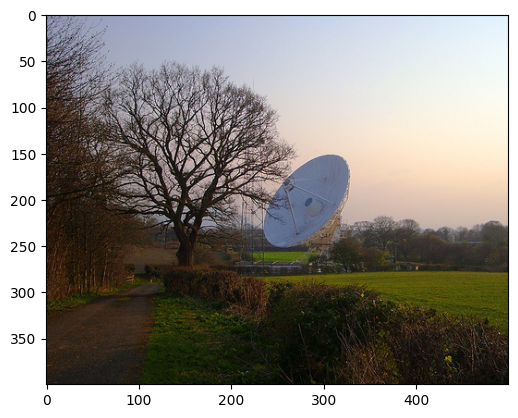


EEG


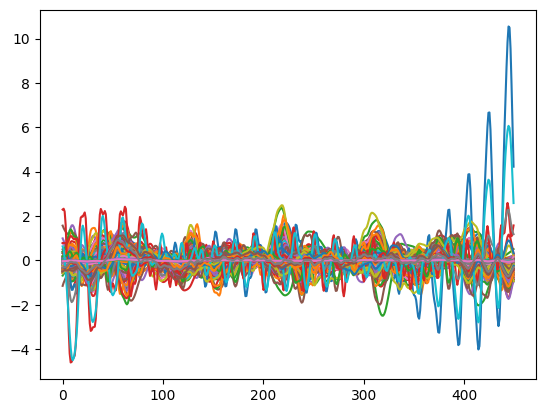

EEG signal shape
(128, 450)

caption
a satellite dish in the middle of a field



In [14]:
img_number = 20
print()
print('Image')
trial_img = cv2.imread(data['image_path'][img_number])
img_fin = cv2.cvtColor(trial_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
plt.imshow(img_fin)
plt.show()

print()
print('EEG')
eeg_signal = eeg_data[img_number]
plt.plot(eeg_signal.T)
plt.show()
print("EEG signal shape")
print(eeg_signal.shape)

print()
print("caption")
print(data['caption'][img_number])

In [18]:
### Converting EEG signals to EEG embeddings

## Using MAE

In [15]:
!pip install braindecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.2/165.2 kB 4.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 10.4 MB/s eta 0:00:00


In [16]:
import torch
import torch.nn as nn
import numpy as np
from braindecode.models import Deep4Net

# Simulated EEG signal (128 channels, 450 time points)
eeg_signal = np.random.randn(128, 450)
eeg_tensor = torch.tensor(eeg_signal, dtype=torch.float32).unsqueeze(0)  # (1, 128, 450)

# Sampling frequency and duration
sfreq = 100
input_window_seconds = 4.5

# Define the model
model = Deep4Net(
    n_chans=128,
    n_outputs=2,  # dummy output size
    input_window_seconds=input_window_seconds,
    sfreq=sfreq,
    final_conv_length='auto'
)
model.eval()

# Extract feature extractor (everything except final classifier)
feature_extractor = nn.Sequential(*list(model.children())[:-1])

# Get the embeddings
with torch.no_grad():
    features = feature_extractor(eeg_tensor)
    embedding_vector = features.view(features.size(0), -1)

print("EEG Embedding Shape:", embedding_vector.shape)


EEG Embedding Shape: torch.Size([1, 200])


/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [17]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from braindecode.models import Deep4Net

# === CONFIGURATION ===
sfreq = 100
input_window_seconds = 4.5
embedding_output_folder = "eeg_embeddings_brainencode"

# Make output folder if it doesn't exist
os.makedirs(embedding_output_folder, exist_ok=True)


# === DEFINE MODEL ===
model = Deep4Net(
    n_chans=128,
    n_outputs=2,  # dummy
    input_window_seconds=input_window_seconds,
    sfreq=sfreq,
    final_conv_length='auto'
)
model.eval()

# Extract feature extractor (remove final classification layer)
feature_extractor = nn.Sequential(*list(model.children())[:-1])

# === EXTRACT AND SAVE EMBEDDINGS ===
for idx in tqdm(range(len(eeg_data)), desc="Extracting EEG Embeddings"):
    eeg_signal = eeg_data[idx]
    eeg_tensor = torch.tensor(eeg_signal, dtype=torch.float32).unsqueeze(0)  # (1, 128, 450)

    with torch.no_grad():
        features = feature_extractor(eeg_tensor)
        embedding_vector = features.view(features.size(0), -1).squeeze(0).numpy()

    embedding_path = os.path.join(embedding_output_folder, f"embedding_{idx}.npy")
    np.save(embedding_path, embedding_vector)

Extracting EEG Embeddings: 100%|██████████| 11965/11965 [00:29<00:00, 399.92it/s]


In [18]:
!zip -r eeg_embeddings_brainencode.zip /kaggle/working/eeg_embeddings_brainencode

  adding: kaggle/working/eeg_embeddings_brainencode/ (stored 0%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_8739.npy (deflated 5%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_857.npy (deflated 6%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_7466.npy (deflated 6%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_8610.npy (deflated 6%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_524.npy (deflated 7%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_4206.npy (deflated 6%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_9613.npy (deflated 5%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_5281.npy (deflated 6%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_5191.npy (deflated 6%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_5653.npy (deflated 7%)
  adding: kaggle/working/eeg_embeddings_brainencode/embedding_3807.npy (deflated 6%)
  

In [19]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00


In [24]:
## Fine Tuning for EEG to Text Conversion

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import open_clip
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from typing import Tuple, List
import logging
from tqdm import tqdm

# Set up logging
#logging.basicConfig(level=logging.INFO)
#logger = logging.getLogger(__name__)

class EEGTextDataset(Dataset):
    """Dataset for EEG and text embeddings."""
    
    def __init__(self, csv_file: str, eeg_dir: str):
        self.df = pd.read_csv(csv_file)
        self.eeg_dir = eeg_dir
        #self.text_dir = self.df['caption']
        
        # Validate paths exist
        if not all(os.path.exists(p) for p in [csv_file, eeg_dir]):
            raise FileNotFoundError("One or more input paths do not exist")
            
        # Load first EEG file to get dimensions
        first_eeg = np.load(os.path.join(self.eeg_dir, self.df.iloc[0]["eeg_file"].replace('eeg','embedding')))
        self.eeg_shape = first_eeg.shape
        self.eeg_flat_dim = np.prod(first_eeg.shape)
        #logger.info(f"EEG embedding shape: {self.eeg_shape}, Flattened dim: {self.eeg_flat_dim}")

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str]:
        eeg_filename = self.df.iloc[idx]["eeg_file"].replace('eeg','embedding')
        #text_filename = self.df.iloc[idx]["Text_Embedding"].replace("_caption","")
        
        eeg_path = os.path.join(self.eeg_dir, eeg_filename)
        #text_path = os.path.join(self.text_dir, text_filename)
        

        # Load and flatten EEG embedding
        eeg_embedding = np.load(eeg_path)
        eeg_embedding_flat = torch.tensor(eeg_embedding.reshape(-1), dtype=torch.float32)
            
        text = self.df.iloc[idx]["caption"]

        return eeg_embedding_flat, text

class EEGTextMapper:
    """Main class for EEG to text mapping using CLIP."""
    
    def __init__(
        self, 
        eeg_input_dim: int,
        clip_dim: int = 512,
        hidden_dim: int = 1024,
        batch_size: int = 32,
        learning_rate: float = 1e-5,
        device: str = None
    ):
        self.eeg_input_dim = eeg_input_dim
        self.clip_dim = clip_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        #logger.info(f"Initializing EEGTextMapper with eeg_input_dim={eeg_input_dim}, clip_dim={clip_dim}")
        
        # Initialize models
        self.clip_model, _, self.preprocess = open_clip.create_model_and_transforms(
            "ViT-B-32",
            pretrained="openai"
        )
        self.clip_model = self.clip_model.to(self.device)
        
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        
        # Create projection network with batch normalization and dropout
        self.eeg_projection = nn.Sequential(
            nn.Linear(self.eeg_input_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_dim, self.clip_dim)
        ).to(self.device)
        
        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            list(self.eeg_projection.parameters()) + list(self.clip_model.parameters()),
            lr=self.learning_rate,
            weight_decay=0.01
        )
        
        self.criterion = nn.CrossEntropyLoss()
        
    def train(
        self, 
        dataloader: DataLoader, 
        epochs: int = 40,
        validation_dataloader: DataLoader = None
    ) -> List[float]:
        """Train the model."""
        losses = []
        best_val_similarity = -1
        
        for epoch in range(epochs):
            epoch_loss = 0
            n_batches = 0
            
            # Training loop
            self.clip_model.train()
            self.eeg_projection.train()
            
            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
            for eeg_embeddings, texts in progress_bar:
                loss = self._training_step(eeg_embeddings, texts)
                epoch_loss += loss.item()
                n_batches += 1
                    
                # Update progress bar
                progress_bar.set_postfix({"loss": epoch_loss / n_batches})

            
            avg_loss = epoch_loss / n_batches
            losses.append(avg_loss)    
            self.save_model("best_model.pt")

                
        return losses
    
    def _training_step(self, eeg_embeddings: torch.Tensor, texts: List[str]) -> torch.Tensor:
        """Perform one training step."""
        eeg_embeddings = eeg_embeddings.to(self.device)
        text_tokens = self.tokenizer(texts).to(self.device)
        
        # Forward pass
        eeg_features = self.eeg_projection(eeg_embeddings)
        text_features = self.clip_model.encode_text(text_tokens)
        
        # Normalize features
        eeg_features = eeg_features / eeg_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity and loss
        logits = (eeg_features @ text_features.T) * 100
        labels = torch.arange(len(texts)).to(self.device)
        
        loss = self.criterion(logits, labels)
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.eeg_projection.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return loss
    
    def evaluate(self, dataloader: DataLoader) -> float:
        """Evaluate the model on a dataset."""
        self.clip_model.eval()
        self.eeg_projection.eval()
        
        with torch.no_grad():
            eeg_embeddings_list, text_embeddings_list = [], []
            
            for eeg_embeddings, texts in dataloader:
                eeg_embeddings = eeg_embeddings.to(self.device)
                text_tokens = self.tokenizer(texts).to(self.device)
                
                eeg_features = self.eeg_projection(eeg_embeddings)
                text_features = self.clip_model.encode_text(text_tokens)
                
                eeg_embeddings_list.append(eeg_features.cpu().numpy())
                text_embeddings_list.append(text_features.cpu().numpy())
            
            eeg_embeddings_matrix = np.vstack(eeg_embeddings_list)
            text_embeddings_matrix = np.vstack(text_embeddings_list)
            
            cosine_sim_matrix = cosine_similarity(eeg_embeddings_matrix, text_embeddings_matrix)
            avg_similarity = np.mean(np.diag(cosine_sim_matrix))
            
            return avg_similarity,cosine_sim_matrix

    def save_model(self, path: str):
        """Save model state."""
        torch.save({
            'eeg_projection_state': self.eeg_projection.state_dict(),
            'clip_model_state': self.clip_model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
        }, path)
    
    def load_model(self, path: str):
        """Load model state."""
        checkpoint = torch.load(path)
        self.eeg_projection.load_state_dict(checkpoint['eeg_projection_state'])
        self.clip_model.load_state_dict(checkpoint['clip_model_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])

# Example usage
if __name__ == "__main__":
    # Create datasets
    train_dataset = EEGTextDataset(
        csv_file="/kaggle/input/eeg-caption-image-csv/image_caption_eeg_mapping.csv",
        eeg_dir="/kaggle/input/eeg-embeddings-brainedencode/kaggle/working/eeg_embeddings_brainencode",
        #text_dir="/kaggle/input/captions-blip2/kaggle/working/captions_BLIP_2"
    )
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Initialize and train model using the flattened EEG dimension
    mapper = EEGTextMapper(
        eeg_input_dim=train_dataset.eeg_flat_dim,
        clip_dim=512,
        hidden_dim=1024
    )
    
    losses = mapper.train(train_loader, epochs=40)
    
    # Evaluate
    similarity, cosine_similarity_matrix = mapper.evaluate(train_loader)
    print(f"Final average cosine similarity: {similarity:.4f}")

/usr/local/lib/python3.10/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
Epoch 40/40: 100%|██████████| 374/374 [01:45<00:00,  3.53it/s, loss=0.337]


Final average cosine similarity: 0.2374


In [25]:
cosine_similarity_matrix

array([[ 0.22142458,  0.0344754 ,  0.02090551, ..., -0.0403998 ,
         0.06624828,  0.04093642],
       [ 0.03967538,  0.22468036,  0.01668558, ...,  0.09382178,
         0.06857542,  0.1029676 ],
       [ 0.06726187,  0.1237621 ,  0.31380963, ...,  0.082895  ,
         0.07762878,  0.06080725],
       ...,
       [ 0.00435007,  0.04071348, -0.00882274, ...,  0.2362727 ,
        -0.00437034,  0.05759964],
       [ 0.09923404, -0.02867862,  0.17508528, ..., -0.03088804,
         0.19909763, -0.00817125],
       [ 0.05067902,  0.1334298 ,  0.15030652, ...,  0.05733253,
         0.03721575,  0.29123864]], dtype=float32)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import open_clip
import pandas as pd
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from typing import Tuple, List
import logging
from tqdm import tqdm

# ... (EEGTextDataset and EEGTextMapper classes remain the same) ...

def predict(eeg_signal: np.ndarray, mapper: EEGTextMapper) -> str:
    """Predicts the most similar text caption for a given EEG signal.

    Args:
        eeg_signal: The EEG signal as a NumPy array.  Make sure it matches the 
                    shape the model was trained on (e.g., flattened if that's
                    how you trained).
        mapper: The trained EEGTextMapper model.

    Returns:
        The predicted text caption (string).  Returns None if no suitable 
        prediction is found (e.g., empty dataloader).
    """

    mapper.clip_model.eval()  # Set to evaluation mode
    mapper.eeg_projection.eval()

    with torch.no_grad():
        eeg_embedding = torch.tensor(eeg_signal.reshape(-1), dtype=torch.float32).unsqueeze(0).to(mapper.device) # Add batch dimension
        eeg_feature = mapper.eeg_projection(eeg_embedding)
        eeg_feature = eeg_feature / eeg_feature.norm(dim=-1, keepdim=True)  # Normalize

        # Get all text embeddings from the training data (or a separate caption dataset)
        all_text_embeddings = []
        all_texts = []
        for eeg_embeddings, texts in train_loader:  # Assuming you have a train_loader available with all the data
            text_tokens = mapper.tokenizer(texts).to(mapper.device)
            text_features = mapper.clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            all_text_embeddings.append(text_features.cpu().numpy())
            all_texts.extend(texts) # Store the actual text captions

        if not all_text_embeddings:  # Handle empty dataset case
            return None

        all_text_embeddings_matrix = np.vstack(all_text_embeddings)

        cosine_sim = cosine_similarity(eeg_feature.cpu().numpy(), all_text_embeddings_matrix)
        predicted_index = np.argmax(cosine_sim)
        predicted_text = all_texts[predicted_index]

        return predicted_text



# Example usage (after training):
if __name__ == "__main__":
    # ... (dataset creation and training as before) ...

    # Load a sample EEG signal (replace with your actual EEG data)
    sample_eeg = np.load("/kaggle/input/eeg-embeddings-brainedencode/kaggle/working/eeg_embeddings_brainencode/embedding_100.npy") # Example - load from file.
    # OR, if you have it in memory:
    # sample_eeg = ... your numpy array ...

    predicted_caption = predict(sample_eeg, mapper)

    if predicted_caption:
        print(f"Predicted Caption: {predicted_caption}")
    else:
        print("No captions found for prediction.")


    # If you want to predict on multiple samples:
    # sample_eegs = [np.load(...), np.load(...), ...]  # List of EEG signals
    # for eeg in sample_eegs:
    #     predicted = predict(eeg, mapper)
    #     print(predicted)

Predicted Caption: a white and blue airplane




Image


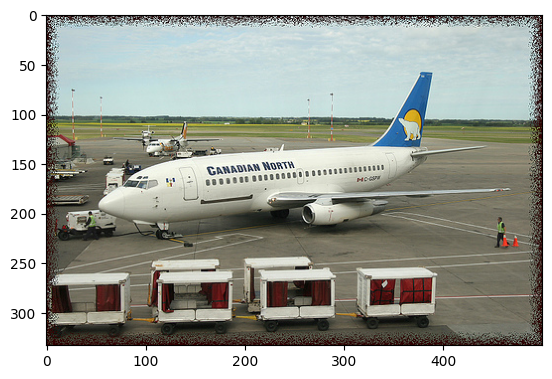


EEG


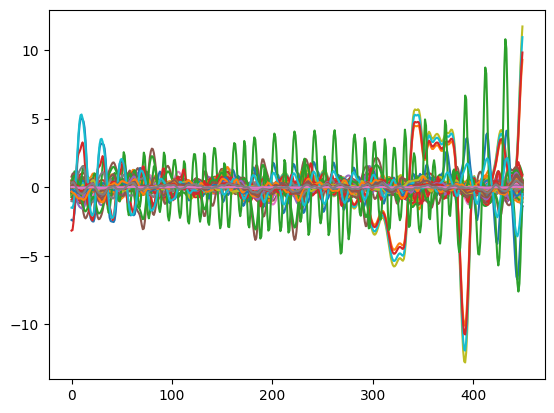

EEG signal shape
(128, 450)

caption
a white and blue airplane



In [27]:
img_number = 100
print()
print('Image')
trial_img = cv2.imread(data['image_path'][img_number])
img_fin = cv2.cvtColor(trial_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
plt.imshow(img_fin)
plt.show()

print()
print('EEG')
eeg_signal = eeg_data[img_number]
plt.plot(eeg_signal.T)
plt.show()
print("EEG signal shape")
print(eeg_signal.shape)

print()
print("caption")
print(data['caption'][img_number])

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 229MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


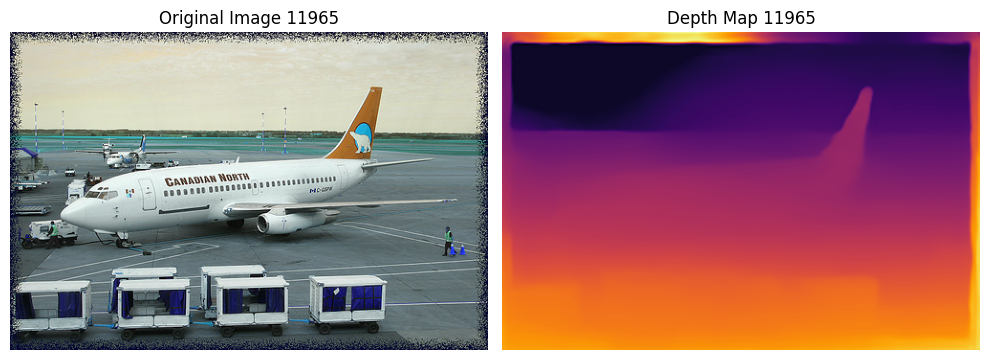

In [28]:
## Image to depth

## Using Midas to get depth from the Images

import os
import torch
import cv2
import numpy as np
import pandas as pd
import base64

def generate_depth_map(image, model, transform):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Apply the transformation and remove any extra dimensions
    input_batch = transform(img_rgb).unsqueeze(0)  # Add batch dimension [1, 3, H, W]
    
    # Remove any extra dimensions accidentally added by the transformation (in case of [1, 1, 3, H, W])
    input_batch = input_batch.squeeze(1)  # Ensure shape is [1, 3, H, W]
    
    # Ensure input is on the correct device
    input_batch = input_batch.to(next(model.parameters()).device)

    # Debugging: Print the input tensor shape to verify it is correct
    #print(f"Input batch shape (after squeezing): {input_batch.shape}")

    with torch.no_grad():
        prediction = model(input_batch)  # Generate depth prediction

    # Debugging: Print prediction shape
    #print(f"Prediction shape: {prediction.shape}")

    # Resize prediction to the original image size
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),  # Add channel dimension
        size=image.shape[:2],  # Resize to match the original image size
        mode="bicubic",
        align_corners=False,
    ).squeeze(1)  # Remove the added channel dimension

    # Convert to numpy and normalize
    depth_map = prediction.cpu().numpy()
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())  # Normalize

    return depth_map

def encode_image(image):
    # If the image has only one channel (grayscale), ensure it's 2D
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image.squeeze(0)  # Remove the extra dimension
    
    # Normalize the image (depth map) to uint8
    if image.dtype != np.uint8:
        image = (255 * (image / np.max(image))).astype(np.uint8)

    # Ensure it is single-channel grayscale for OpenCV
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Encode as PNG
    retval, buffer = cv2.imencode('.png', image)
    
    # Return base64 encoded string
    return base64.b64encode(buffer).decode('utf-8')

model_type = "MiDaS_small"  # MiDaS small version
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

# Load transforms for the model
transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = transforms.small_transform  # For MiDaS_small

img_number = 100
trial_img = cv2.imread(data['image_path'][img_number])
img_fin = cv2.cvtColor(trial_img, cv2.COLOR_BGR2RGB) 

# Generate depth map
depth_map = generate_depth_map(trial_img, midas, transform)

plt.figure(figsize=(10, 5))
    
# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_fin, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
plt.title(f"Original Image {idx + 1}")
plt.axis("off")
    
# Depth Map
plt.subplot(1, 2, 2)
depth_map_squeezed = np.squeeze(depth_map)  # Remove the extra dimension
plt.imshow(depth_map_squeezed, cmap='inferno')  # Use a colormap for better depth perception
plt.title(f"Depth Map {idx + 1}")
plt.axis("off")
    
plt.tight_layout()
plt.show()

In [35]:
## reconstructing image

import torch
from diffusers import StableDiffusionDepth2ImgPipeline
from transformers import AutoTokenizer
import numpy as np
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
from IPython.display import display

# Initialize Hugging Face diffusion model (pre-trained depth2img model)
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2")
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device)  # Move the pipeline to the correct device

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

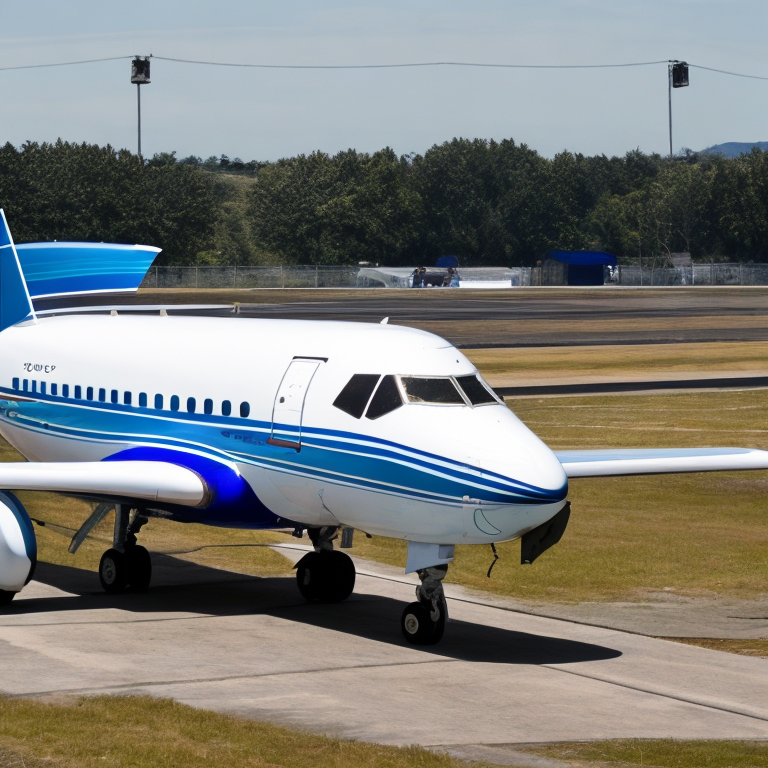

0.1939803895146956


In [36]:
## reconstructing image

import torch
from diffusers import StableDiffusionDepth2ImgPipeline
from transformers import AutoTokenizer
import numpy as np
from PIL import Image
import cv2
from skimage.metrics import structural_similarity as ssim
from IPython.display import display
from diffusers import StableDiffusionPipeline
import torch
import numpy as np
from PIL import Image
import torch.nn.functional as F
from IPython.display import display

# Preprocessing function for depth maps
def preprocess_depth_map(depth_map, target_height, target_width, device):
    # Convert the depth map from NumPy array to a PyTorch tensor
    if isinstance(depth_map, np.ndarray):
        depth_map = torch.tensor(depth_map)
    
    # Ensure the depth map is in the right format (N, C, H, W)
    if depth_map.ndimension() == 2:
        depth_map = depth_map.unsqueeze(0).unsqueeze(0)  # Adding batch and channel dimensions
    elif depth_map.ndimension() == 3:
        depth_map = depth_map.unsqueeze(1)  # Adding channel dimension
    
    depth_map_tensor = depth_map.float()
    
    # Resize the tensor to the target size
    if depth_map_tensor.shape[2] != target_height or depth_map_tensor.shape[3] != target_width:
        depth_map_tensor = F.interpolate(depth_map_tensor, size=(target_height, target_width), mode="bicubic", align_corners=False)
    
    # Ensure it is on the correct device
    depth_map_tensor = depth_map_tensor.to(device)
    
    return depth_map_tensor


from PIL import Image
import numpy as np

# Stable Diffusion image reconstruction function
def stable_diffusion_image_reconstruct(prompt, depth_map, device):
    # Define target dimensions directly
    target_height, target_width = 63, 46
    
    # Preprocess the depth map to match the model's input expectations
    depth_image_tensor = preprocess_depth_map(depth_map, target_height, target_width, device)
    blank_image = np.zeros((depth_map.shape[1], depth_map.shape[2], 3), dtype=np.float32)  # Adjusted the dimensions
    blank_image_pil = Image.fromarray((blank_image * 255).astype(np.uint8))
    
    generated_image = pipe(prompt=prompt, image=blank_image_pil, depth_map=depth_image_tensor).images[0]
    
    return generated_image

from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np
from PIL import Image

def calculate_ssim(original_image, generated_image):
    # Convert numpy arrays to PIL images if necessary
    if isinstance(original_image, np.ndarray):
        original_image = Image.fromarray((original_image * 255).astype(np.uint8)) if original_image.max() <= 1 else Image.fromarray(original_image)
    
    if isinstance(generated_image, np.ndarray):
        generated_image = Image.fromarray((generated_image * 255).astype(np.uint8)) if generated_image.max() <= 1 else Image.fromarray(generated_image)

    # Resize generated image if dimensions don't match
    if original_image.size != generated_image.size:
        generated_image = generated_image.resize(original_image.size)

    # Convert images to grayscale
    original_gray = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2GRAY)
    generated_gray = cv2.cvtColor(np.array(generated_image), cv2.COLOR_RGB2GRAY)
    
    # Compute SSIM
    try:
        ssim_score, _ = ssim(original_gray, generated_gray, full=True)
    except ValueError as ve:
        raise ValueError(f"SSIM computation error: {ve}. Ensure both images are 2D arrays of the same dimensions.")
    
    return ssim_score


device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = predicted_caption

# Generate image using depth map (you might need to adjust how depth is fed into the model)
generated_image = stable_diffusion_image_reconstruct(prompt, depth_map, device)

# Display the image inline in the Kaggle notebook
display(generated_image)

ssim_123 = calculate_ssim(img_fin, generated_image)
print(ssim_123)